In [1]:
# data manipulation
import pandas as pd
import numpy as np

# data visualization 
import matplotlib.pyplot as plt
# json
import json
# sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics

# lgb
import lightgbm as lgb

# datatime
import datetime
%matplotlib inline

In [2]:
def load_df(csv_path, nrows=None):
    '''
    load csv file and convert json columns to normal columns
    '''
    json_columns = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in json_columns},
                     dtype={'fullVisitorId': 'str'},
                     nrows=nrows)
    
    for column in json_columns:
        column_df = pd.io.json.json_normalize(list(df[column].values))
        column_df.columns = [f'{column}.{sub_column}' for sub_column in column_df.columns]
        df = df.drop(column, axis=1).join(column_df)
        
    return df

In [36]:
# load and transform data
train_df = load_df('train.csv')
test_df = load_df('test.csv')

In [106]:
def run_lgb(X_train, y_train, X_dev, y_dev, X_test):
    '''
    wrap train, dev and test dataset in LGB
    '''
    params = {'learning_rate': 0.03,
            'objective':'regression',
            'metric':'rmse',
            'num_leaves': 31,
            'verbose': 1,
            "subsample": 0.99,
            "colsample_bytree": 0.99,
            "random_state":42,
            'max_depth': 15,
            'lambda_l2': 0.02085548700474218,
            'lambda_l1': 0.004107624022751344,
            'bagging_fraction': 0.7934712636944741,
            'feature_fraction': 0.686612409641711,
            'min_child_samples': 21}
    
    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_dev = lgb.Dataset(X_dev, label=y_dev)
    model = lgb.train(params, lgb_train, valid_sets=[lgb_dev], early_stopping_rounds=150, verbose_eval=150)
    pred_y_test = model.predict(X_test, num_iteration=model.best_iteration) 
    pred_y_dev = model.predict(X_dev, num_iteration=model.best_iteration)
    return model, pred_y_dev, pred_y_test

In [101]:
from sklearn.model_selection import GroupKFold

def get_oof(train_df, test_df, select_features):
    
    def get_fold(train_df, kfold = 5):   
        '''
        kfold based on unique fullVisitorId
        '''
        unique_vis = np.array(sorted(train_df['fullVisitorId'].unique()))
        folds = GroupKFold(n_splits=kfold)
        fold_ids = []
        ids = np.arange(train_df.shape[0])
        for train_vis, dev_vis in folds.split(X=unique_vis, y=unique_vis, groups=unique_vis):
            fold_ids.append([
                ids[train_df['fullVisitorId'].isin(unique_vis[train_vis])],
                ids[train_df['fullVisitorId'].isin(unique_vis[dev_vis])]
            ])
        return fold_ids
    
    oof_pred = np.zeros(train_df.shape[0])
    test_pred = np.zeros(test_df.shape[0])
    fold_ids = get_fold(train_df)
    
    for i, (train_idx, dev_idx) in enumerate(fold_ids):
        print('processing {} fold: '.format(i))

        train_id = train_df['fullVisitorId'].iloc[train_idx].values
        train_X = train_df[select_features].iloc[train_idx]
        train_y = train_df['totals.transactionRevenue'].iloc[train_idx].values
        train_y = np.log1p(train_y)

        dev_id = train_df['fullVisitorId'].iloc[dev_idx].values
        dev_X = train_df[select_features].iloc[dev_idx]
        dev_y = train_df['totals.transactionRevenue'].iloc[dev_idx].values  
        dev_y = np.log1p(dev_y)
        
        test_id = test_df['fullVisitorId'].values
        test_X = test_df[num_columns + cat_columns].values

        model, pred_dev, pred_test = run_lgb(train_X, train_y, dev_X, dev_y, test_X)
        pred_dev[pred_dev < 0] = 0
        pred_test[pred_test < 0] = 0

        oof_pred[dev_idx] = np.expm1(pred_dev)
        test_pred += np.expm1(pred_test) / len(fold_ids)
        
        # n fold rmse 
        pred_dev_df = pd.DataFrame({'fullVisitorId': dev_id})
        pred_dev_df['transactionRevenue'] = dev_y
        pred_dev_df['predictedRevenue'] = np.expm1(pred_dev)
        pred_dev_df = pred_dev_df.groupby('fullVisitorId')[['transactionRevenue', 'predictedRevenue']].sum()
        rmse_score = rmse(np.log1p(pred_dev_df['transactionRevenue'].values), np.log1p(pred_dev_df['predictedRevenue'].values))
        print('fold rmse:{}'.format(rmse_score))
    return oof_pred, test_pred, model   

In [6]:
# define the metrics: rmse(root mean square error)
def rmse(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power((y - y0), 2)))

In [102]:
num_columns = ['totals.bounces', 'totals.hits', 'totals.newVisits', 'totals.pageviews', 'visitNumber', 'visitStartTime']
cat_columns = ['channelGrouping',
               'device.browser',
               'device.deviceCategory',
               'device.operatingSystem',
               'geoNetwork.city',
               'geoNetwork.continent',
               'geoNetwork.country',
               'geoNetwork.metro',
               'geoNetwork.networkDomain',
               'geoNetwork.region',
               'geoNetwork.subContinent',
               'trafficSource.adContent',
               'trafficSource.adwordsClickInfo.adNetworkType',
               'trafficSource.adwordsClickInfo.gclId',
               'trafficSource.adwordsClickInfo.isVideoAd',
               'trafficSource.adwordsClickInfo.page',
               'trafficSource.adwordsClickInfo.slot',
               'trafficSource.campaign',
               'trafficSource.isTrueDirect',
               'trafficSource.keyword',
               'trafficSource.medium',
               'trafficSource.referralPath',
               'trafficSource.source']

In [37]:
# preprocess data, the select featrues are infered from the 
def preprocess(train_df, test_df, num_columns, cat_columns):
    # encode categorical columns
    for column in cat_columns:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[column].values.astype('str')) + list(test_df[column].values.astype('str')))
        train_df[column] = lbl.transform(list(train_df[column].values.astype('str')))
        test_df[column] = lbl.transform(list(test_df[column].values.astype('str')))
    
    train_df[num_columns] = train_df[num_columns].fillna(0)
    train_df[num_columns] = train_df[num_columns].astype(float)
    test_df[num_columns] = test_df[num_columns].fillna(0)
    test_df[num_columns] = test_df[num_columns].astype(float)
    
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].fillna(0)
    train_df['totals.transactionRevenue'] = train_df['totals.transactionRevenue'].astype(float)
    
    return train_df, test_df

In [38]:
train_df, test_df = preprocess(train_df, test_df, num_columns, cat_columns)

In [107]:
oof_pred, test_pred, model = get_oof(train_df, test_df, num_columns+cat_columns)

processing 0 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.66069
fold rmse:0.8291808967256659
processing 1 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.63954
fold rmse:0.8300926929015011
processing 2 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.64698
fold rmse:0.839052364846896
processing 3 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.62898
fold rmse:0.8472834377920914
processing 4 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.66899
fold rmse:0.8535104959674873


In [72]:
# create time series features
def create_time_features(df):
    df['visitDate'] = pd.to_datetime(df['visitStartTime'], unit='s')
    df['dow'] = df['visitDate'].dt.dayofweek
    df['hours'] = df['visitDate'].dt.hour
    df['dom'] = df['visitDate'].dt.day
    train_df.sort_values(['fullVisitorId', 'visitDate'], ascending=True, inplace=True)
    df['nextSession1'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(1)).astype(int)
    df['nextSession2'] = (df['visitDate'] - df[['fullVisitorId', 'visitDate']].groupby('fullVisitorId')['visitDate'].shift(-1)).astype(int)
    df['pageviews_per_day'] = df['date'].map(df[['date', 'totals.pageviews']].groupby('date')['totals.pageviews'].sum())
    df['ratio_pageviews'] = df['totals.pageviews'] / df['pageviews_per_day']
    return df

In [73]:
train_df = create_time_features(train_df)

In [74]:
test_df = create_time_features(test_df)

In [108]:
additional_columns = ['dow', 'hours', 'dom', 'nextSession1', 'nextSession2', 'ratio_pageviews', 'pageviews_per_day']

In [109]:
num_columns = [num_column for num_column in num_columns if num_column != 'visitStartTime']

In [111]:
oof_pred, test_pred, model = get_oof(train_df, test_df, num_columns+cat_columns+additional_columns)

processing 0 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.64272
fold rmse:0.8857741652562837
processing 1 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.61965
fold rmse:0.8808068747407015
processing 2 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.62099
fold rmse:0.8966625995978433
processing 3 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.61376
fold rmse:0.9080675492113578
processing 4 fold: 
Training until validation scores don't improve for 150 rounds.
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.64593
fold rmse:0.9185639282371533


Text(0.5,1,'Light-GBM Feature Importance')

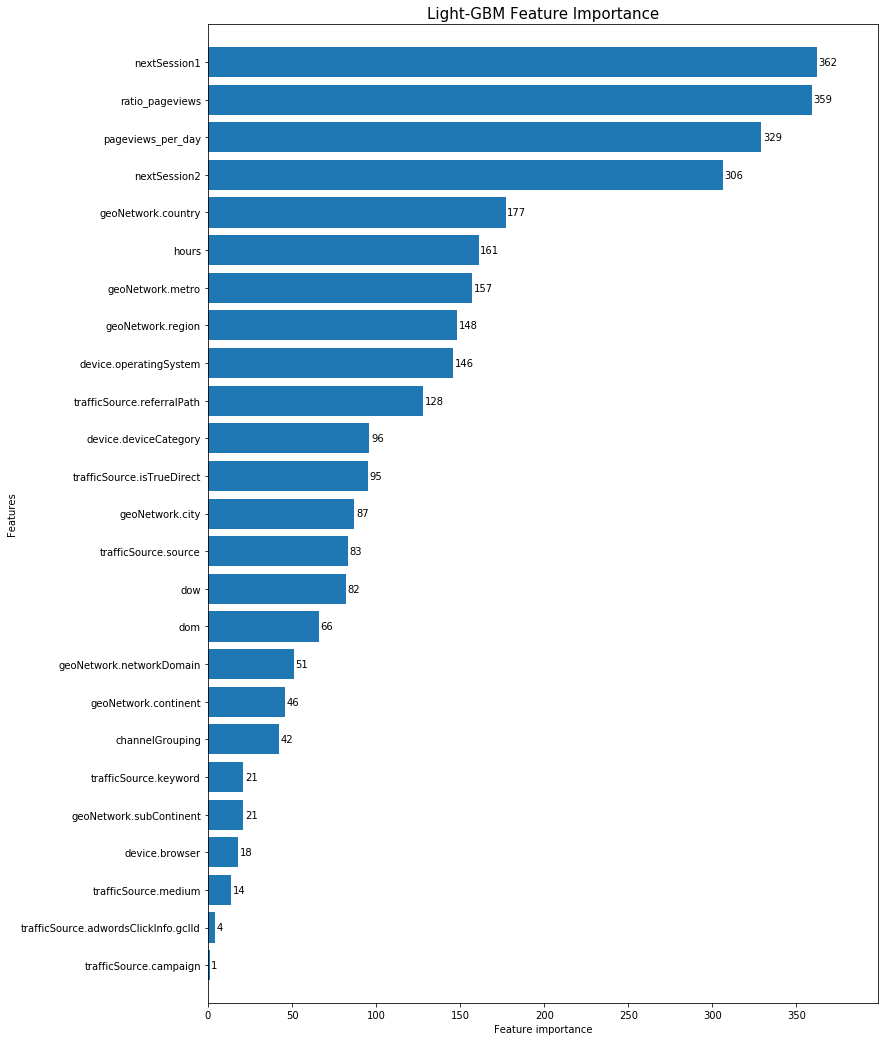

In [98]:
# visualize feature importance
fig, ax = plt.subplots(figsize=(12, 18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title('Light-GBM Feature Importance', fontsize=15)

In [99]:
submission = pd.read_csv('sample_submission.csv')
test_id = test_df['fullVisitorId'].values
pred_test_df = pd.DataFrame({'fullVisitorID': test_id})
pred_test_df['predict'] = test_pred
pred_test_df = pred_test_df.groupby('fullVisitorID')['predict'].sum().reset_index()
pred_test_df['predict'] = np.log1p(pred_test_df['predict'].values)

submission = submission.merge(pred_test_df, left_on='fullVisitorId', right_on='fullVisitorID')
submission =submission.drop(['PredictedLogRevenue', 'fullVisitorID'], axis=1)
submission.columns = ['fullVisitorId', 'PredictedLogRevenue']

In [100]:
submission.to_csv('lgb_submission.csv', index=0)